const       float64
Assault       int64
UrbanPop      int64
Rape        float64
dtype: object
Descriptive statistics:


,Assault,UrbanPop,Rape
count,50.000000,50.000000,50.000000
mean,170.760000,65.540000,21.232000
std,83.337661,14.474763,9.366385
min,45.000000,32.000000,7.300000
25%,109.000000,54.500000,15.075000
50%,159.000000,66.000000,20.100000
75%,249.000000,77.750000,26.175000
max,337.000000,91.000000,46.000000


Correlation matrix for the predictors:


,Assault,UrbanPop,Rape
Assault,1.000000,0.258872,0.665241
UrbanPop,0.258872,1.000000,0.411341
Rape,0.665241,0.411341,1.000000


Correlations between predictors greater than 0.6 ?:


,Assault,UrbanPop,Rape
Assault,True,False,True
UrbanPop,False,True,False
Rape,True,False,True


There does not seem to be multicolinearity among the predictors.


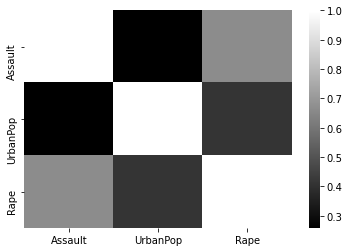

<Figure size 432x288 with 0 Axes>

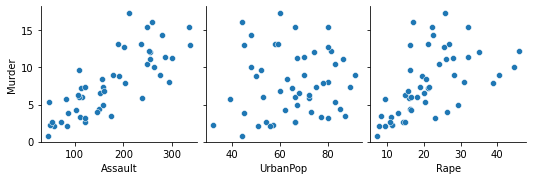

Proportion of the Assault values greater than 3 standard deviations from the mean:
0.0
Proportion of the UrbanPop values greater than 3 standard deviations from the mean:
0.0
Proportion of the Rape values greater than 3 standard deviations from the mean:
0.0

The predictors meet the requirements for linear regression.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
import seaborn as sns
import scipy.stats

# importing and subsetting the data

# data obtained from 'https://forge.scilab.org/index.php/p/rdataset/source/tree/master/csv/datasets/USArrests.csv'

# documentation for data: 'https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/USArrests'

df = pd.read_csv('USArrests.csv')

df.rename(columns = {'Unnamed: 0':'State'}, inplace = True) 

outcome = df['Murder'].copy()

predictors = df[['Assault', 'UrbanPop', 'Rape']].copy()


# adding an intercept to the predictors
predictors = sm.add_constant(predictors) 


# checking the data types (to check for nans etc.)
print(predictors.dtypes)


# descriptive statistics, and checking for colinearity with a correlation matrix and pairplot
not_intercept = predictors.columns[predictors.columns != 'const']

print('Descriptive statistics:')
display(predictors[not_intercept].describe())

corr_mat = predictors[not_intercept].corr()
print('Correlation matrix for the predictors:')
display(corr_mat)

# setting a threshold for bivariate correlations between predictors that may indicate multicolinearity
# this link recommends 0.7 but I will be more conservative: https://blog.clairvoyantsoft.com/correlation-and-collinearity-how-they-can-make-or-break-a-model-9135fbe6936a
severe_colin_cutoff = 0.6 

print('Correlations between predictors greater than '+str(severe_colin_cutoff)+' ?:')
display(np.abs(corr_mat) > severe_colin_cutoff )

# counting the number of predictions greater than the colinearity cutoff
num_of_predictor_correlations = np.count_nonzero(np.abs(corr_mat.values) > severe_colin_cutoff ) - len(predictors[not_intercept].columns)

# if correlations > 0.7 exist between more than two variables, printing a warning
if num_of_predictor_correlations > 2:
    print('There are several correlations > '+str(severe_colin_cutoff )+' between the predictors.')
    print('Check for multicolinearity!')
else:
    print('There does not seem to be multicolinearity among the predictors.')

# plotting a heatmap of the correlation matrix for the predictors
plt.figure()
sns.heatmap(corr_mat, cmap = 'gray' )
plt.show()

# visually checking for outliers with a pairplot
plt.figure()
sns.pairplot(data = df, x_vars = not_intercept, y_vars = 'Murder')
plt.show()

# finding the proportion of the data points in the predictors which are more than 3 standard deviations from the mean
# of the predictor. As per https://docs.oracle.com/cd/E17236_01/epm.1112/cb_statistical/frameset.htm?ch07s02s10s01.html

outlier_detection_props = np.array([])
for i in not_intercept:
    print('Proportion of the '+str(i)+' values greater than 3 standard deviations from the mean:') 
    prop_detected = np.count_nonzero(np.abs(predictors[i].values) > np.mean(predictors[i].values) + 3 * np.std(predictors[i].values, ddof = 1))/len(predictors[i])
    print(prop_detected)
    outlier_detection_props = np.append(outlier_detection_props, prop_detected)
    if prop_detected != 0:
        print('Check '+str(i)+' for outliers!')
        
# printing the results of the preliminary data checks
# e.g. absence of several correlations between predictors? absence of extreme outliers?

if num_of_predictor_correlations <= 2 and np.count_nonzero(outlier_detection_props > 0) == 0:
    print('\nThe predictors meet the requirements for linear regression.')
else:
    print('\nColinearity or extreme outliers are present. Check the predictors.')

                            OLS Regression Results                            
Dep. Variable:                 Murder   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     31.42
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           3.32e-11
Time:                        19:20:44   Log-Likelihood:                -116.14
No. Observations:                  50   AIC:                             240.3
Df Residuals:                      46   BIC:                             247.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2766      1.738      1.885      0.0

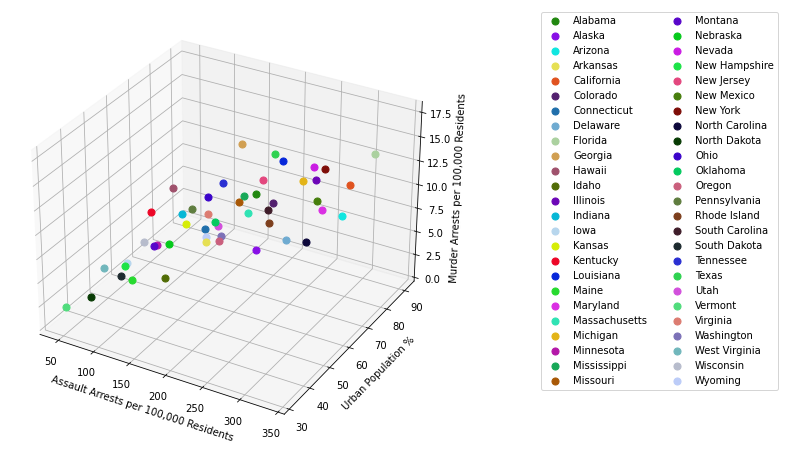

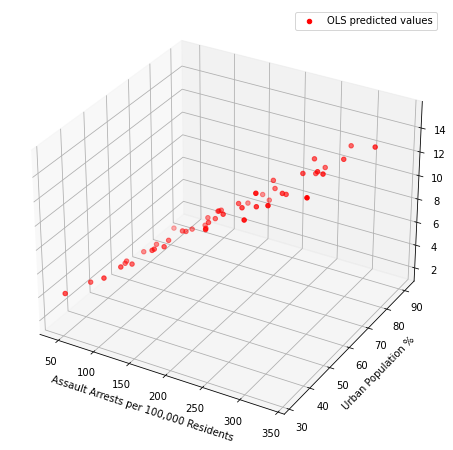


The Omnibus test indicates that the residuals are normally distributed.
The Durbin-Watson test indicates that the residuals are not autocorrelated.
The Breusch-Pagan Lagrange Multiplier test indicates that the residuals are homoscedastic.

The tests on the residuals show that the assumptions of linear regression were met.


In [2]:
# fitting a linear regression model

mod = sm.OLS(outcome, predictors).fit()

print_mod = mod.summary()
print(print_mod)

predicted_values = mod.predict(predictors)

# plotting the data and predicted data

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')


# generating a colormap for the datapoints
zero_1 = np.random.uniform(0,1, size = 100000)
cmap = np.random.choice(zero_1, replace = False, size = len(df)+2)

for i in range(len(df)):
    ax.scatter(df['Assault'][i], df['UrbanPop'][i], df['Murder'][i],  label = df['State'][i],
               color = [cmap[i], cmap[i+1], cmap[i+2]], s =50)
ax.scatter(df['Assault'], df['UrbanPop'], predicted_values, 'x', color = 'black')

plt.xlabel('Assault Arrests per 100,000 Residents')
plt.ylabel('Urban Population %')
plt.legend(loc='upper center', bbox_to_anchor=(1.5, 1), ncol =2)
ax.set_zlabel('Murder Arrests per 100,000 Residents')
plt.show()

fig_2 = plt.figure(figsize = (10,8))
ax_2 = fig_2.add_subplot(111, projection='3d')
ax_2.scatter(df['Assault'], df['UrbanPop'], predicted_values, label = 'OLS predicted values',
            color = 'red')
plt.xlabel('Assault Arrests per 100,000 Residents')
plt.ylabel('Urban Population %')
plt.legend(loc='upper right')
ax.set_zlabel('Murder Arrests per 100,000 Residents')
plt.show()


# checking that the assumptions of linear regression regarding the distribution of residuals are met
# e.g. normality, independence of errors and homogeneity of variance

norm_test = scipy.stats.normaltest(mod.resid)
autocorr_test = sm.stats.stattools.durbin_watson(mod.resid)
homosced_test = sm.stats.diagnostic.het_breuschpagan(mod.resid, predictors)

print()
if norm_test.pvalue > 0.05:
    print('The Omnibus test indicates that the residuals are normally distributed.')
elif norm_test.pvalue <= 0.05:
    print('The Omnibus test indicates that the residuals are NOT normally distributed.')
    
if autocorr_test > 1.5  and autocorr_test < 2.5 : # https://www.statisticshowto.com/durbin-watson-test-coefficient/
    print('The Durbin-Watson test indicates that the residuals are not autocorrelated.')
elif autocorr_test <= 1.5 or autocorr_test >= 2.5:
    print('The Durbin-Watson test indicates that the residuals ARE autocorrelated.')
    
if homosced_test[1] > 0.05 and homosced_test[-1] > 0.05:
    print('The Breusch-Pagan Lagrange Multiplier test indicates that the residuals are homoscedastic.')
    
elif homosced_test[1] <= 0.05 or homosced_test[-1] <=  0.05:
    print('The Breusch-Pagan Lagrange Multiplier test indicates that the residuals are HETEROscedastic')
    
if norm_test.pvalue > 0.05 and autocorr_test > 1.5 and autocorr_test < 2.5 and homosced_test[1] > 0.05 and homosced_test[-1] > 0.05:
    print('\nThe tests on the residuals show that the assumptions of linear regression were met.')
else:
    print('Some of the assumptions of linear regression regarding the distribution of residuals were not met. See the specific test printouts above.')

                            OLS Regression Results                            
Dep. Variable:                 Murder   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     86.45
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           2.60e-12
Time:                        19:20:46   Log-Likelihood:                -118.26
No. Observations:                  50   AIC:                             240.5
Df Residuals:                      48   BIC:                             244.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6317      0.855      0.739      0.4

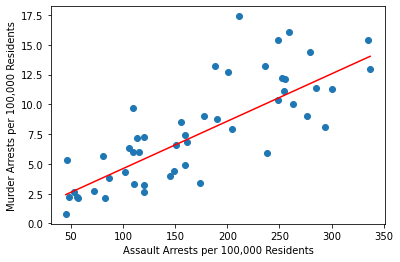


The Omnibus test indicates that the residuals are normally distributed.
The Durbin-Watson test indicates that the residuals are not autocorrelated.
The Breusch-Pagan Lagrange Multiplier test indicates that the residuals are homoscedastic.

The tests on the residuals show that the assumptions of linear regression were met.


In [3]:
# dropping the nonsignificant predictors from the model

sig_predictors = predictors['Assault']
sig_predictors = sm.add_constant(sig_predictors)

# fitting a linear regression model

mod_2 = sm.OLS(outcome, sig_predictors).fit()

print_mod_2 = mod_2.summary()
print(print_mod_2)

# calculating a regression line

b0 = mod_2.params[0]
b1 = mod.params[1]
x1_assault = np.linspace(min(predictors['Assault']), max(predictors['Assault']))

y_hat = b0 + b1*x1_assault

# plotting the data and the regression line

plt.figure()
plt.scatter(sig_predictors['Assault'], outcome)
plt.plot(x1_assault, y_hat, color = 'red')
plt.xlabel('Assault Arrests per 100,000 Residents')
plt.ylabel('Murder Arrests per 100,000 Residents')
plt.show()

# checking that the assumptions of linear regression regarding the distribution of residuals are met
# e.g. normality, independence of errors and homogeneity of variance

norm_test_mod_2 = scipy.stats.normaltest(mod_2.resid)
autocorr_test_mod_2 = sm.stats.stattools.durbin_watson(mod_2.resid)
homosced_test_mod_2 = sm.stats.diagnostic.het_breuschpagan(mod_2.resid, predictors)

print()
if norm_test_mod_2.pvalue > 0.05:
    print('The Omnibus test indicates that the residuals are normally distributed.')
elif norm_test_mod_2.pvalue <= 0.05:
    print('The Omnibus test indicates that the residuals are NOT normally distributed.')
    
if autocorr_test_mod_2 > 1.5  and autocorr_test_mod_2 < 2.5 : # https://www.statisticshowto.com/durbin-watson-test-coefficient/
    print('The Durbin-Watson test indicates that the residuals are not autocorrelated.')
elif autocorr_test_mod_2 <= 1.5 or autocorr_test_mod_2 >= 2.5:
    print('The Durbin-Watson test indicates that the residuals ARE autocorrelated.')
    
if homosced_test_mod_2[1] > 0.05 and homosced_test_mod_2[-1] > 0.05:
    print('The Breusch-Pagan Lagrange Multiplier test indicates that the residuals are homoscedastic.')
    
elif homosced_test_mod_2[1] <= 0.05 or homosced_test_mod_2[-1] <=  0.05:
    print('The Breusch-Pagan Lagrange Multiplier test indicates that the residuals are HETEROscedastic')
    
if norm_test_mod_2.pvalue > 0.05 and autocorr_test_mod_2 > 1.5 and autocorr_test_mod_2 < 2.5 and homosced_test_mod_2[1] > 0.05 and homosced_test_mod_2[-1] > 0.05:
    print('\nThe tests on the residuals show that the assumptions of linear regression were met.')
else:
    print('Some of the assumptions of linear regression regarding the distribution of residuals were not met. See the specific test printouts above.')